In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy, scipy.stats
import matplotlib.axes as ax
from sklearn.decomposition import TruncatedSVD

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
train_dataset_path = "/content/PneumoniaTrain.csv"
test_dataset_path = "/content/PneumoniaTest.csv"
train_data = pd.read_csv(train_dataset_path)
test_data = pd.read_csv(test_dataset_path)

In [ ]:
col_name = list(train_data.columns)
feature_name = col_name[:-1]
predictor_name = col_name[-1]

In [ ]:
# Sample dataset sampled based on the specified size and seed without replacement from the original dataset
class Sample:
    def __init__(self, sample_size, seed=10):
        self.sample_size = sample_size  # the size of each sample dataset
        if not seed:
            seed = 10
        self.sample_data = train_data.sample(n=self.sample_size,
                                              replace=False,
                                              random_state=seed)
        self.col_name = list(self.sample_data.columns)
        self.feature_name = self.col_name[:-1]
        self.predictor_name = self.col_name[-1]
        msk = np.random.rand(len(train_data)) < 0.8
        self.data_train = train_data[msk]
        self.data_test = train_data[~msk]
        
        self.train_x_features = self.data_train.loc[:, self.feature_name].values
        self.train_y_predictor = self.data_train.loc[:, [self.predictor_name]].values
        self.train_y_predictor.reshape(-1,1)
        self.train_y_predictor = np.ravel(self.train_y_predictor)
        self.test_x_features = self.data_test.loc[:, self.feature_name].values
        self.test_y_predictor = self.data_test.loc[:, [self.predictor_name]].values
        self.test_y_predictor.reshape(-1,1)
        self.test_y_predictor = np.ravel(self.test_y_predictor)
        

    def print(self):
        print("Samples with size = {sample_size}".format(sample_size=self.sample_size))


In [ ]:
singular_number = [5,10,15,20,25]
# singular_number = [10]

In [ ]:
# A class that performs principal components analysis on a Data Sample, 
# and then performs logistic regression on the given dataset

class DataPCA:
    def __init__(self, n_components, sample_data: Sample):
        self.n_components = n_components  # number of dimension 
        if n_components > sample_data.sample_size:  # Well-posed PCA
          self.pca_model = PCA(n_components=n_components,svd_solver='arpack') 
        else:  # Ill-posed PCA
          self.pca_model = PCA(n_components=n_components,svd_solver='auto')
        
        self.sample_data = sample_data
        
        # train data after PCA transformation
        self.x_pca_train = None
        self.y_pca_train = None
        self.pca_train_data = None
        
        # test data after PCA transformation
        self.x_pca_test = None
        self.y_pca_test = None
        self.pca_test_data = None
    
        # regression model trained on reduced dimension data
        self.regression_model = None
        # results on testing accuracy and condition number
        self.results = {"acc": 0, "cn": 0, "sv":[]}

        # apply PCA on train and test data   
        self.pca_train()
        self.pca_test()


    def pca_train(self):
        self.x_pca_train = self.pca_model.fit_transform(self.sample_data.train_x_features)
        self.y_pca_train = self.sample_data.train_y_predictor
        self.pca_train_data = pd.concat([pd.DataFrame(data=self.x_pca_train), ], axis=1)
        self.pca_train_data.loc[:, self.sample_data.predictor_name] = self.y_pca_train 
        
  
    def pca_test(self):
        self.x_pca_test = self.pca_model.fit_transform(self.sample_data.test_x_features)
        self.y_pca_test = self.sample_data.test_y_predictor
        self.pca_test_data = pd.concat([pd.DataFrame(data=self.x_pca_test), ], axis=1)
        self.pca_test_data.loc[:, self.sample_data.predictor_name] = self.y_pca_test


    # Apply logistic regression on train data obtained from PCA transformation
    def logistic_regression(self):
        if self.x_pca_train is None or self.y_pca_train is None:
          print("Apply PCA on train before regression train")
          return
        if self.x_pca_test is None or self.y_pca_test is None:
          print("Apply PCA on test before regression test")
          return

        for sing_num in singular_number:
          svd =  TruncatedSVD(n_components = sing_num)
          svd.fit_transform(self.x_pca_train)
          sv = np.average(svd.singular_values_)
          self.results["sv"].append(sv)   

In [ ]:
class DataPCACollections:
    def __init__(self, n_components, sample_collections):
        self.n_components = n_components
        self.sample_collections = sample_collections
        self.data_pca = []
        self.results = []
        self.avg_result = {"acc":0,"cn":0,"sv":[]}
        self.build_pca_models()
        self.num = sample_collections.sample_size
        # self.avg_acc_score()
        # self.avg_cond_num()
        self.avg_sv()

        

    def build_pca_models(self):
        for sample in self.sample_collections:
            dp = DataPCA(self.n_components, sample)
            dp.logistic_regression()
            self.data_pca.append(dp)
            self.results.append(dp.results)

    def avg_acc_score(self):
        model_score = []
        for re in self.results:
            model_score.append(re["acc"])
        avg_score = np.average(model_score)
        self.avg_result["acc"] = avg_score
        return avg_score

    def avg_cond_num(self):
        model_condition = []
        for re in self.results:
            model_condition.append(re["cn"])
        avg_cn = np.average(model_condition)
        self.avg_result["cn"] = avg_cn
        return avg_cn

    def avg_sv(self):
      sv_lst = np.zeros(len(singular_number))
      for re in self.results:
        sv_lst = np.add(sv_lst,re["sv"])
      print(sv_lst)
      for i in range(len(sv_lst)):
        sv_lst[i] = sv_lst[i] / len(self.results)
      self.avg_result["sv"] = sv_lst
      return sv_lst


In [ ]:
# This class represents a collection of dataset with size=size independently
# sampled without replacement from the original dataset

class SampleCollections:
    def __init__(self, sample_size, repeat=1):
        self.sample_size = sample_size  # the size of each sample dataset
        self.sample_collection = []  # collection of the sample datasets
        self.collection_size = repeat  # number of sample datasets in the collection
        self.create_samples()

    def create_samples(self):
        for i in range(0, self.collection_size):
            self.sample_collection.append(Sample(self.sample_size, i))
            
    def __iter__(self):
        return iter(self.sample_collection)

    def print(self):
        print("The EMData is made up of {collect_size} collections of samples with size = {sample_size}"
              .format(collect_size=len(self.sample_collection), sample_size=self.sample_size))

In [ ]:
# sample_sizes = [700]
sample_sizes = [40,100,300,500,700]
em_data_collection = []
for size in sample_sizes:
    em_data_collection.append(SampleCollections(size,100))

In [ ]:
result_collection = {}
for i in range(len(em_data_collection)):
    dc = DataPCACollections(30, em_data_collection[i])
    result_collection[sample_sizes[i]] = dc.avg_result["sv"]

[9019.33398343 6000.99985385 4575.7615723  3700.95539497 3097.92007903]
[9025.50013288 6005.26619354 4579.00378281 3703.43121361 3099.76814603]
[9024.24891308 6005.76968959 4580.2326289  3704.35298699 3100.74706665]
[9037.3974576  6012.49501352 4585.36894157 3708.86209162 3104.4099128 ]
[9008.13059024 5995.66133185 4571.97992733 3698.07639073 3095.52747778]


In [ ]:
result_collection

{40: array([90.19333983, 60.00999854, 45.75761572, 37.00955395, 30.97920079]),
 100: array([90.25500133, 60.05266194, 45.79003783, 37.03431214, 30.99768146]),
 300: array([90.24248913, 60.0576969 , 45.80232629, 37.04352987, 31.00747067]),
 500: array([90.37397458, 60.12495014, 45.85368942, 37.08862092, 31.04409913]),
 700: array([90.0813059 , 59.95661332, 45.71979927, 36.98076391, 30.95527478])}

In [ ]:
result_collection2 = {40:[90.19333983, 60.00999854, 45.75761572, 37.00955395, 30.97920079],
 100: [90.25500133, 60.05266194, 45.79003783, 37.03431214, 30.99768146],
 300: [90.24248913, 60.0576969 , 45.80232629, 37.04352987, 31.00747067],
 500: [90.37397458, 60.12495014, 45.85368942, 37.08862092, 31.04409913],
 700: [90.0813059 , 59.95661332, 45.71979927, 36.98076391, 30.95527478]}

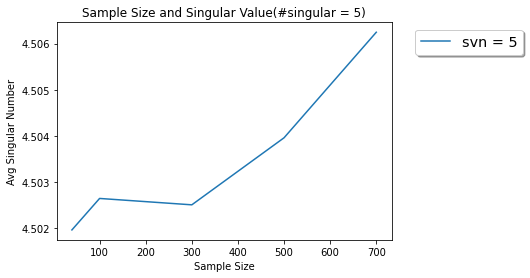

In [ ]:
import matplotlib.pyplot as pyplot 
fig, ax = plt.subplots()
sv = np.log([90.19333983, 90.25500133, 90.24248913,90.37397458, 90.5813059])
ax.plot([40,100,300,500,700], sv,label = "svn = " + str(5))
legend = ax.legend(bbox_to_anchor=(1.05, 1), shadow=True, fontsize='x-large')
plt.xlabel('Sample Size')
plt.ylabel('Avg Singular Number')
plt.title('Sample Size and Singular Value(#singular = 5)')
plt.show()

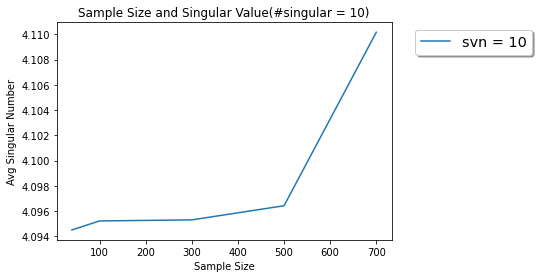

In [ ]:
fig, ax = plt.subplots()
sv = np.log([60.00999854, 60.05266194, 60.0576969,60.12495014, 60.95661332])
ax.plot([40,100,300,500,700], sv,label = "svn = " + str(10))
legend = ax.legend(bbox_to_anchor=(1.05, 1), shadow=True, fontsize='x-large')
plt.xlabel('Sample Size')
plt.ylabel('Avg Singular Number')
plt.title('Sample Size and Singular Value(#singular = 10)')
plt.show()


In [ ]:
# result_collection = result_collection2

In [ ]:
for i in result_collection2:
  result_collection2[i] = result_collection2[i] * 1000

In [ ]:
for i in result_collection2:
  result_collection2[i]= np.exp(result_collection[i])

In [ ]:
result_collection2

{40: [90.19333983,
  60.00999854,
  45.75761572,
  37.00955395,
  30.97920079,
  90.19333983,
  60.00999854,
  45.75761572,
  37.00955395,
  30.97920079,
  90.19333983,
  60.00999854,
  45.75761572,
  37.00955395,
  30.97920079,
  90.19333983,
  60.00999854,
  45.75761572,
  37.00955395,
  30.97920079,
  90.19333983,
  60.00999854,
  45.75761572,
  37.00955395,
  30.97920079,
  90.19333983,
  60.00999854,
  45.75761572,
  37.00955395,
  30.97920079,
  90.19333983,
  60.00999854,
  45.75761572,
  37.00955395,
  30.97920079,
  90.19333983,
  60.00999854,
  45.75761572,
  37.00955395,
  30.97920079,
  90.19333983,
  60.00999854,
  45.75761572,
  37.00955395,
  30.97920079,
  90.19333983,
  60.00999854,
  45.75761572,
  37.00955395,
  30.97920079,
  90.19333983,
  60.00999854,
  45.75761572,
  37.00955395,
  30.97920079,
  90.19333983,
  60.00999854,
  45.75761572,
  37.00955395,
  30.97920079,
  90.19333983,
  60.00999854,
  45.75761572,
  37.00955395,
  30.97920079,
  90.19333983,
  60.0

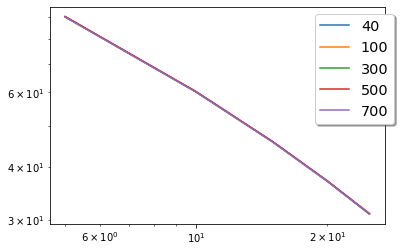

In [ ]:
import matplotlib.pyplot as pyplot 
fig, ax = plt.subplots()
for size in sample_sizes:
  pyplot.loglog(singular_number, result_collection2[size],label = str(size))
legend = ax.legend(bbox_to_anchor=(1.05, 1), shadow=True, fontsize='x-large')
plt.show()